# Classwork 6 


Work through the following datasets, determining best fits for each data set (predictor value/y value in parens). To better evaluate or improve this process, try including:

* Increase the number of training points N. This might give us a training set with more coverage, and lead to greater accuracy.
* Increase the degree d of the polynomial. This might allow us to more closely fit the training data, and lead to a better result
* Add more features. If we were to, for example, perform a linear regression using x, x√, x−1, or other functions, we might hit on a functional form which can better be mapped to the value of y.

In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.api as sm

%matplotlib inline

DATA_DIR = '../data/'

## Predicting stopping distance

In [146]:
# Load the data
df = pd.read_csv(DATA_DIR + 'cars1920.csv')

In [147]:
# explore the features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 2 columns):
speed    50 non-null int64
dist     50 non-null int64
dtypes: int64(2)
memory usage: 1.2 KB


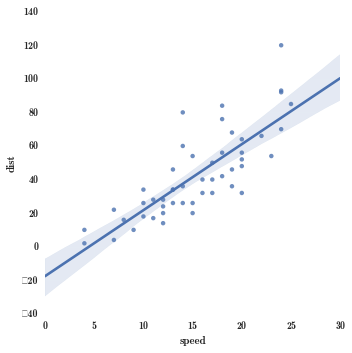

In [148]:
# explore the types of relationship you should model for, linear?
sns.lmplot("speed", "dist", df);

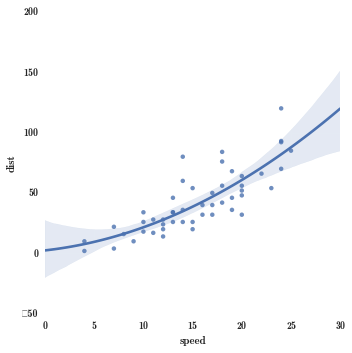

In [149]:
# explore the types of relationship you should model for, second order polynomial?
sns.lmplot("speed", "dist", df, order=2);

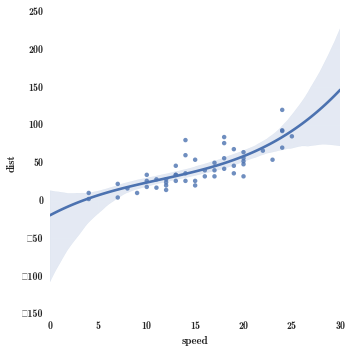

In [150]:
# explore the types of relationship you should model for, third order polynomial?
sns.lmplot("speed", "dist", df, order=3);

Since it is not strictly a linear relationship, we are going to use polynomial features. 
But there are two problems with this.

### Orthogonal Polynomials

First, we can generate highly correlated regressors by taking powers of `x`, leading to noisy parameter estimates. The input `x` are evenly space numbers on the interval `[0, 1]`. So `x` and $x^2$ are going to have a correlation over `95%`. Similar with $x^2$ and $x^3$. The solution to this is to use orthogonalized polynomial functions: tranformations of `x` that, when summed, result in polynomial functions, but are orthogonal (therefore uncorrelated) with each other.

Luckily, we can easily calculate these transformations using patsy. The `C(x, Poly)` transform computes orthonormal polynomial functions of `x`, then we’ll extract out various orders of the polynomial. So `Xpoly[:, :2]` selects out the `0th` and 1st order functions, then when summed will give us a first order polynomial (i.e. linear). Similarly `Xpoly[: :4]` gives us the 0th through 3rd order functions, which sum up to a cubic polynomial.

Math review : [Orthogonal Polynomials](http://mathoverflow.net/questions/38864/visualizing-orthogonal-polynomials)

In [151]:
speed = df.speed.values
dist = df.dist.values
y = dist

speed_poly = dmatrix('C(speed, Poly)')

In [152]:
speed_poly

DesignMatrix with shape (50, 19)
  Columns:
    ['Intercept',
     'C(speed, Poly).Linear',
     'C(speed, Poly).Quadratic',
     'C(speed, Poly).Cubic',
     'C(speed, Poly)^4',
     'C(speed, Poly)^5',
     'C(speed, Poly)^6',
     'C(speed, Poly)^7',
     'C(speed, Poly)^8',
     'C(speed, Poly)^9',
     'C(speed, Poly)^10',
     'C(speed, Poly)^11',
     'C(speed, Poly)^12',
     'C(speed, Poly)^13',
     'C(speed, Poly)^14',
     'C(speed, Poly)^15',
     'C(speed, Poly)^16',
     'C(speed, Poly)^17',
     'C(speed, Poly)^18']
  Terms:
    'Intercept' (column 0), 'C(speed, Poly)' (columns 1:19)
  (to view full data, use np.asarray(this_obj))

In [153]:
# Only Speed
speed_poly1 = dmatrix('speed', df)

# Only Speed^2
speed_sq = dmatrix('np.power(speed,2)', df)

# Speed + Speed^2
speed_poly2 = dmatrix('speed + np.power(speed,2)')

# Orthoganal Polynnomials for ^3, ^5 and ^25
speed_poly3 = speed_poly[:, :4]
speed_poly5 = speed_poly[:, :6]
speed_poly25 = speed_poly[:, :26]

In [154]:
Xs = [speed_poly1, speed_sq, speed_poly2, speed_poly3, speed_poly5, speed_poly25]

In [155]:
speed_poly2

DesignMatrix with shape (50, 3)
  Intercept  speed  np.power(speed, 2)
          1      4                  16
          1      4                  16
          1      7                  49
          1      7                  49
          1      8                  64
          1      9                  81
          1     10                 100
          1     10                 100
          1     10                 100
          1     11                 121
          1     11                 121
          1     12                 144
          1     12                 144
          1     12                 144
          1     12                 144
          1     13                 169
          1     13                 169
          1     13                 169
          1     13                 169
          1     14                 196
          1     14                 196
          1     14                 196
          1     14                 196
          1     15              

### Overfitting

The problem we encounter now is how to choose what order polynomial to fit to the data. Any data can be fit well (i.e. have a high $R^2$) if we use a high enough order polynomial. But we will start to over-fit our data; capturing noise specific to our sample, leading to poor predictions on new data. The graph below shows the fits to the data of a straight line, a 3rd-order polynomial, a 5th-order polynomial, and a 25th-order polynomial.

In [156]:
speed_poly1_pred = sm.OLS(y, speed_poly1).fit().predict()
speed_sq_pred = sm.OLS(y, speed_sq).fit().predict()
speed_poly2_pred = sm.OLS(y, speed_poly2).fit().predict()
speed_poly3_pred = sm.OLS(y, speed_poly3).fit().predict()
speed_poly5_pred = sm.OLS(y, speed_poly5).fit().predict()
speed_poly25_pred = sm.OLS(y, speed_poly25).fit().predict()

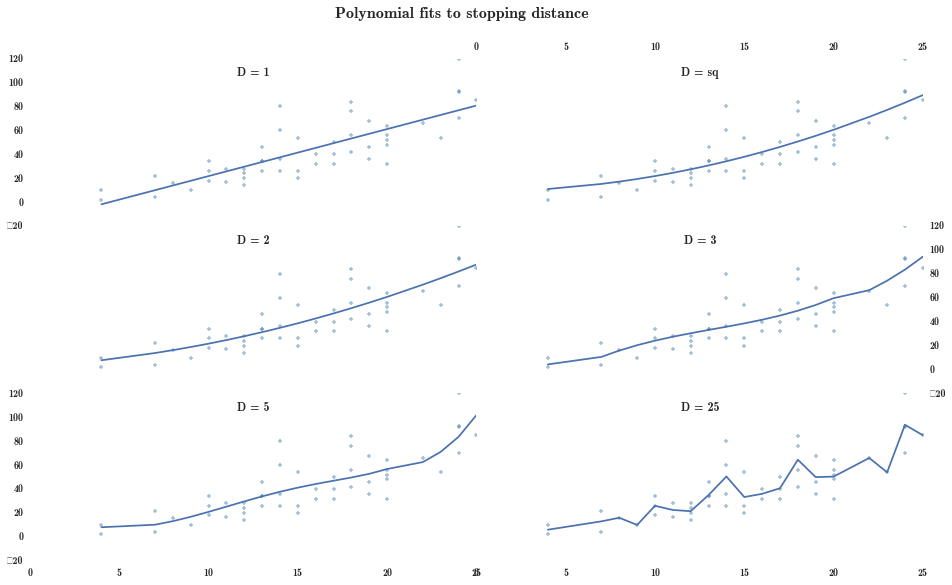

In [157]:
import matplotlib.pyplot as plt

plt.figure()

fig, ax = plt.subplots(3, 2, sharex = True, sharey = True, figsize=(16,9))
fig.subplots_adjust(hspace = 0.0, wspace = 0.0)
fig.suptitle('Polynomial fits to stopping distance', fontsize = 16.0)

# Iterate through panels (a), model predictions (p), and the polynomial 
# degree of the model (d). Plot the data, the predictions, and label
# the graph to indicate the degree used.
preds = [speed_poly1_pred, speed_sq_pred, speed_poly2_pred,
         speed_poly3_pred, speed_poly5_pred, speed_poly25_pred]
orders = ['1', 'sq', '2', '3', '5', '25']

for a, p, d in zip(ax.ravel(), preds, orders):
    a.plot(df.speed.values, df.dist.values, '.', color = 'steelblue', alpha = 0.5)
    a.plot(df.speed.values, p)
    a.text(.5, .95, 'D = ' + d, fontsize = 12,
           verticalalignment = 'top',
           horizontalalignment = 'center',
           transform = a.transAxes)
    a.grid()
    
# Alternate axes that have tick labels to avoid overlap.
plt.setp(fig.axes[2].get_yaxis().get_ticklabels(), visible = False)
plt.setp(fig.axes[3].get_yaxis(), ticks_position = 'right')   
plt.setp(fig.axes[1].get_xaxis(), ticks_position = 'top')
plt.setp(fig.axes[3].get_xaxis().get_ticklabels(), visible = False);

 Notice how the last fit gives us all kinds of degrees of freedom to capture specific datapoints, and the excessive “wiggles” look like we’re fitting to noise.

### Scoring your models

In [158]:
for order, X in zip(orders, Xs):
    print "%s : %.03f" % (order, sm.OLS(y, X).fit().rsquared)

1 : 0.651
sq : 0.666
2 : 0.667
3 : 0.672
5 : 0.680
25 : 0.792


Without cross-validation - which we'll be covering soon, it would appear that the `sq` model is preferred as that provides us with a smooth line, 

## Predicting City and Highway MPG.

In [159]:
# Load the data
df = pd.read_csv(DATA_DIR + 'cars93.csv')

### Inspect the Data

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 27 columns):
Manufacturer          93 non-null object
Model                 93 non-null object
Type                  93 non-null object
Min.Price             93 non-null float64
Price                 93 non-null float64
Max.Price             93 non-null float64
MPG.city              93 non-null int64
MPG.highway           93 non-null int64
AirBags               93 non-null object
DriveTrain            93 non-null object
Cylinders             93 non-null object
EngineSize            93 non-null float64
Horsepower            93 non-null int64
RPM                   93 non-null int64
Rev.per.mile          93 non-null int64
Man.trans.avail       93 non-null object
Fuel.tank.capacity    93 non-null float64
Passengers            93 non-null int64
Length                93 non-null int64
Wheelbase             93 non-null int64
Width                 93 non-null int64
Turn.circle           93 non-null int64


### Inspecting Datatypes

In [161]:
# Check if any of the columns marked as 'object' shouldn't be int or float instead
objs = df.columns[df.dtypes == object]
df[objs]

,Manufacturer,Model,Type,AirBags,DriveTrain,Cylinders,Man.trans.avail,Origin,Make
0,Acura,Integra,Small,None,Front,4,Yes,non-USA,Acura Integra
1,Acura,Legend,Midsize,Driver & Passenger,Front,6,Yes,non-USA,Acura Legend
2,Audi,90,Compact,Driver only,Front,6,Yes,non-USA,Audi 90
3,Audi,100,Midsize,Driver & Passenger,Front,6,Yes,non-USA,Audi 100
4,BMW,535i,Midsize,Driver only,Rear,4,Yes,non-USA,BMW 535i
5,Buick,Century,Midsize,Driver only,Front,4,No,USA,Buick Century
6,Buick,LeSabre,Large,Driver only,Front,6,No,USA,Buick LeSabre
7,Buick,Roadmaster,Large,Driver only,Rear,6,No,USA,Buick Roadmaster
8,Buick,Riviera,Midsize,Driver only,Front,6,No,USA,Buick Riviera
9,Cadillac,DeVille,Large,Driver only,Front,8,No,USA,Cadillac DeVille


Yuhk - full stops in the column names, let's get rid of those first.

In [162]:
df.columns = [col.replace('.','') for col in df.columns]

In [163]:
# Hmmm why is the cylinder not an integer dtype?
df.Cylinders

0     4
1     6
2     6
3     6
4     4
5     4
6     6
7     6
8     6
9     8
10    8
11    4
12    4
13    6
14    4
15    6
16    6
17    8
18    8
19    6
20    4
21    6
22    4
23    4
24    4
25    6
26    4
27    6
28    4
29    6
     ..
63    4
64    4
65    6
66    6
67    4
68    4
69    6
70    6
71    4
72    4
73    4
74    6
75    6
76    6
77    4
78    4
79    3
80    4
81    4
82    3
83    4
84    4
85    4
86    4
87    4
88    5
89    4
90    6
91    4
92    5
Name: Cylinders, dtype: object

In [165]:
# Let's try coercing it into an int datatype
[int(v) for v in df.Cylinders if type(v)]

ValueError: invalid literal for int() with base 10: 'rotary'

In [166]:
# Ah, there's a row with a peculiar value
df[df.Cylinders == 'rotary']

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGcity,MPGhighway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turncircle,Rearseatroom,Luggageroom,Weight,Origin,Make
56,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,NaN,NaN,2895,non-USA,Mazda RX-7


In [167]:
# Let's set the number of cylinders to 0
df.loc[df.Cylinders == 'rotary', 'Cylinders'] = 0

In [168]:
# Change the Cylinder datatype
df.Cylinders = df.Cylinders.astype(int)
df.Cylinders.dtype

dtype('int64')

### Handling Missing Values

In [169]:
# Check for missing values

# Create a helper function to catch columns with any missing values
# Logic : Check if there are any missing values, and sum them. True
# counts as '1' so that's why this elegant solution works! 
is_null = lambda col: sum(pd.isnull(df[col]))

# Logic : return (column name, missing value count) for each of the
# columns in the dataframe, _if_ there are any missing values
missing_values = [(col,is_null(col)) for col in df if is_null(col)]
missing_values

[('Rearseatroom', 2), ('Luggageroom', 11)]

Two columns have missing values, let's take a closer look at the data and figure out why that's the case.

#### Rear.seat.room

In [170]:
select = missing_values[0][0]
df[df[select].isnull()]

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGcity,MPGhighway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turncircle,Rearseatroom,Luggageroom,Weight,Origin,Make
18,Chevrolet,Corvette,Sporty,34.6,38.0,41.5,17,25,Driver only,Rear,...,2,179,96,74,43,NaN,NaN,3380,USA,Chevrolet Corvette
56,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,NaN,NaN,2895,non-USA,Mazda RX-7


OK - so they are both sports cars. But let's sort by `Rear.seat.room` and see whether it's just that there _is_ no rear seat space, or whether the data is truly missing.

In [171]:
df.sort('Rearseatroom')[['Manufacturer','Model','Type','Rearseatroom']]

,Manufacturer,Model,Type,Rearseatroom
59,Mercury,Capri,Sporty,19.0
27,Dodge,Stealth,Sporty,20.0
34,Ford,Probe,Sporty,23.0
84,Toyota,Celica,Sporty,23.0
79,Subaru,Justy,Small,23.5
40,Honda,Prelude,Sporty,23.5
45,Hyundai,Scoupe,Sporty,23.5
83,Toyota,Tercel,Small,24.0
33,Ford,Mustang,Sporty,24.0
39,Geo,Storm,Sporty,24.5


There are no cars where the `Rear.seat.room` is set to zero, so after a bit of Googling, you'd find that indeed these two cars don't allow for passengers in the back, so we can set these values to zero.

In [172]:
crit = df['Rearseatroom'].isnull()
df.loc[crit, 'Rearseatroom'] = 0

#### Luggage.room

Now let's inspect the missing values for `Luggage.room`

In [173]:
select = missing_values[1][0]
df[df[select].isnull()]

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGcity,MPGhighway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turncircle,Rearseatroom,Luggageroom,Weight,Origin,Make
15,Chevrolet,Lumina_APV,Van,14.7,16.3,18.0,18,23,None,Front,...,7,178,110,74,44,30.5,NaN,3715,USA,Chevrolet Lumina_APV
16,Chevrolet,Astro,Van,14.7,16.6,18.6,15,20,None,4WD,...,8,194,111,78,42,33.5,NaN,4025,USA,Chevrolet Astro
18,Chevrolet,Corvette,Sporty,34.6,38.0,41.5,17,25,Driver only,Rear,...,2,179,96,74,43,0.0,NaN,3380,USA,Chevrolet Corvette
25,Dodge,Caravan,Van,13.6,19.0,24.4,17,21,Driver only,4WD,...,7,175,112,72,42,26.5,NaN,3705,USA,Dodge Caravan
35,Ford,Aerostar,Van,14.5,19.9,25.3,15,20,Driver only,4WD,...,7,176,119,72,45,30.0,NaN,3735,USA,Ford Aerostar
55,Mazda,MPV,Van,16.6,19.1,21.7,18,24,None,4WD,...,7,190,110,72,39,27.5,NaN,3735,non-USA,Mazda MPV
56,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,0.0,NaN,2895,non-USA,Mazda RX-7
65,Nissan,Quest,Van,16.7,19.1,21.5,17,23,None,Front,...,7,190,112,74,41,27.0,NaN,4100,non-USA,Nissan Quest
69,Oldsmobile,Silhouette,Van,19.5,19.5,19.5,18,23,None,Front,...,7,194,110,74,44,30.5,NaN,3715,USA,Oldsmobile Silhouette
86,Toyota,Previa,Van,18.9,22.7,26.6,18,22,Driver only,4WD,...,7,187,113,71,41,35.0,NaN,3785,non-USA,Toyota Previa


Lot's of vans, and the two sports cars we just dealt with for missing Rear.seat.room values! Let's see how Vans 
are dealt with.

In [174]:
df[df.Type == 'Van']

,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGcity,MPGhighway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turncircle,Rearseatroom,Luggageroom,Weight,Origin,Make
15,Chevrolet,Lumina_APV,Van,14.7,16.3,18.0,18,23,None,Front,...,7,178,110,74,44,30.5,NaN,3715,USA,Chevrolet Lumina_APV
16,Chevrolet,Astro,Van,14.7,16.6,18.6,15,20,None,4WD,...,8,194,111,78,42,33.5,NaN,4025,USA,Chevrolet Astro
25,Dodge,Caravan,Van,13.6,19.0,24.4,17,21,Driver only,4WD,...,7,175,112,72,42,26.5,NaN,3705,USA,Dodge Caravan
35,Ford,Aerostar,Van,14.5,19.9,25.3,15,20,Driver only,4WD,...,7,176,119,72,45,30.0,NaN,3735,USA,Ford Aerostar
55,Mazda,MPV,Van,16.6,19.1,21.7,18,24,None,4WD,...,7,190,110,72,39,27.5,NaN,3735,non-USA,Mazda MPV
65,Nissan,Quest,Van,16.7,19.1,21.5,17,23,None,Front,...,7,190,112,74,41,27.0,NaN,4100,non-USA,Nissan Quest
69,Oldsmobile,Silhouette,Van,19.5,19.5,19.5,18,23,None,Front,...,7,194,110,74,44,30.5,NaN,3715,USA,Oldsmobile Silhouette
86,Toyota,Previa,Van,18.9,22.7,26.6,18,22,Driver only,4WD,...,7,187,113,71,41,35.0,NaN,3785,non-USA,Toyota Previa
88,Volkswagen,Eurovan,Van,16.6,19.7,22.7,17,21,None,Front,...,7,187,115,72,38,34.0,NaN,3960,non-USA,Volkswagen Eurovan


OK - turns out none of the vans are considered to have 'luggage room' , so let's also set ll these values to zero.

In [175]:
crit = df['Luggageroom'].isnull()
df.loc[crit, 'Luggageroom'] = 0

Sanity check to make sure we can move on now.

In [176]:
missing_values = [(col,is_null(col)) for col in df if is_null(col)]
len(missing_values)

0

### Split out design matrix and response vector

In [192]:
# Let's build a model for MPG.city
y = df['MPGcity']
# y = df['MPG.highway']

# Lazy selection of all numeric columns without MPG
selection = df._get_numeric_data().columns - ['MPGcity','MPGhighway']
X = df[selection]
X.head()

,Cylinders,EngineSize,Fueltankcapacity,Horsepower,Length,Luggageroom,MaxPrice,MinPrice,Passengers,Price,RPM,Rearseatroom,Revpermile,Turncircle,Weight,Wheelbase,Width
0,4,1.8,13.2,140,177,11,18.8,12.9,5,15.9,6300,26.5,2890,37,2705,102,68
1,6,3.2,18.0,200,195,15,38.7,29.2,5,33.9,5500,30.0,2335,38,3560,115,71
2,6,2.8,16.9,172,180,14,32.3,25.9,5,29.1,5500,28.0,2280,37,3375,102,67
3,6,2.8,21.1,172,193,17,44.6,30.8,6,37.7,5500,31.0,2535,37,3405,106,70
4,4,3.5,21.1,208,186,13,36.2,23.7,4,30.0,5700,27.0,2545,39,3640,109,69


### Feature Selection

Is there a potential relationship between the predictors and the response variable?

In [184]:
from sklearn import feature_selection as fs

def f_regression_feature_selection(input, response):    
# use this against your feature matrix to determine p-values for
# each feature (we care about the second array it returns).
    return fs.univariate_selection.f_regression(input, response)    

#### ValueError?

If your attempt of running `f_regression_feature_selection` with a current `X` and `y` failed with the error:

```bash
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```
this meant that you likely didn't properly clean out the missing values from your design matrix.

### Visual Exploration of Correlation

In [182]:
data = pd.DataFrame(X,y).reset_index()

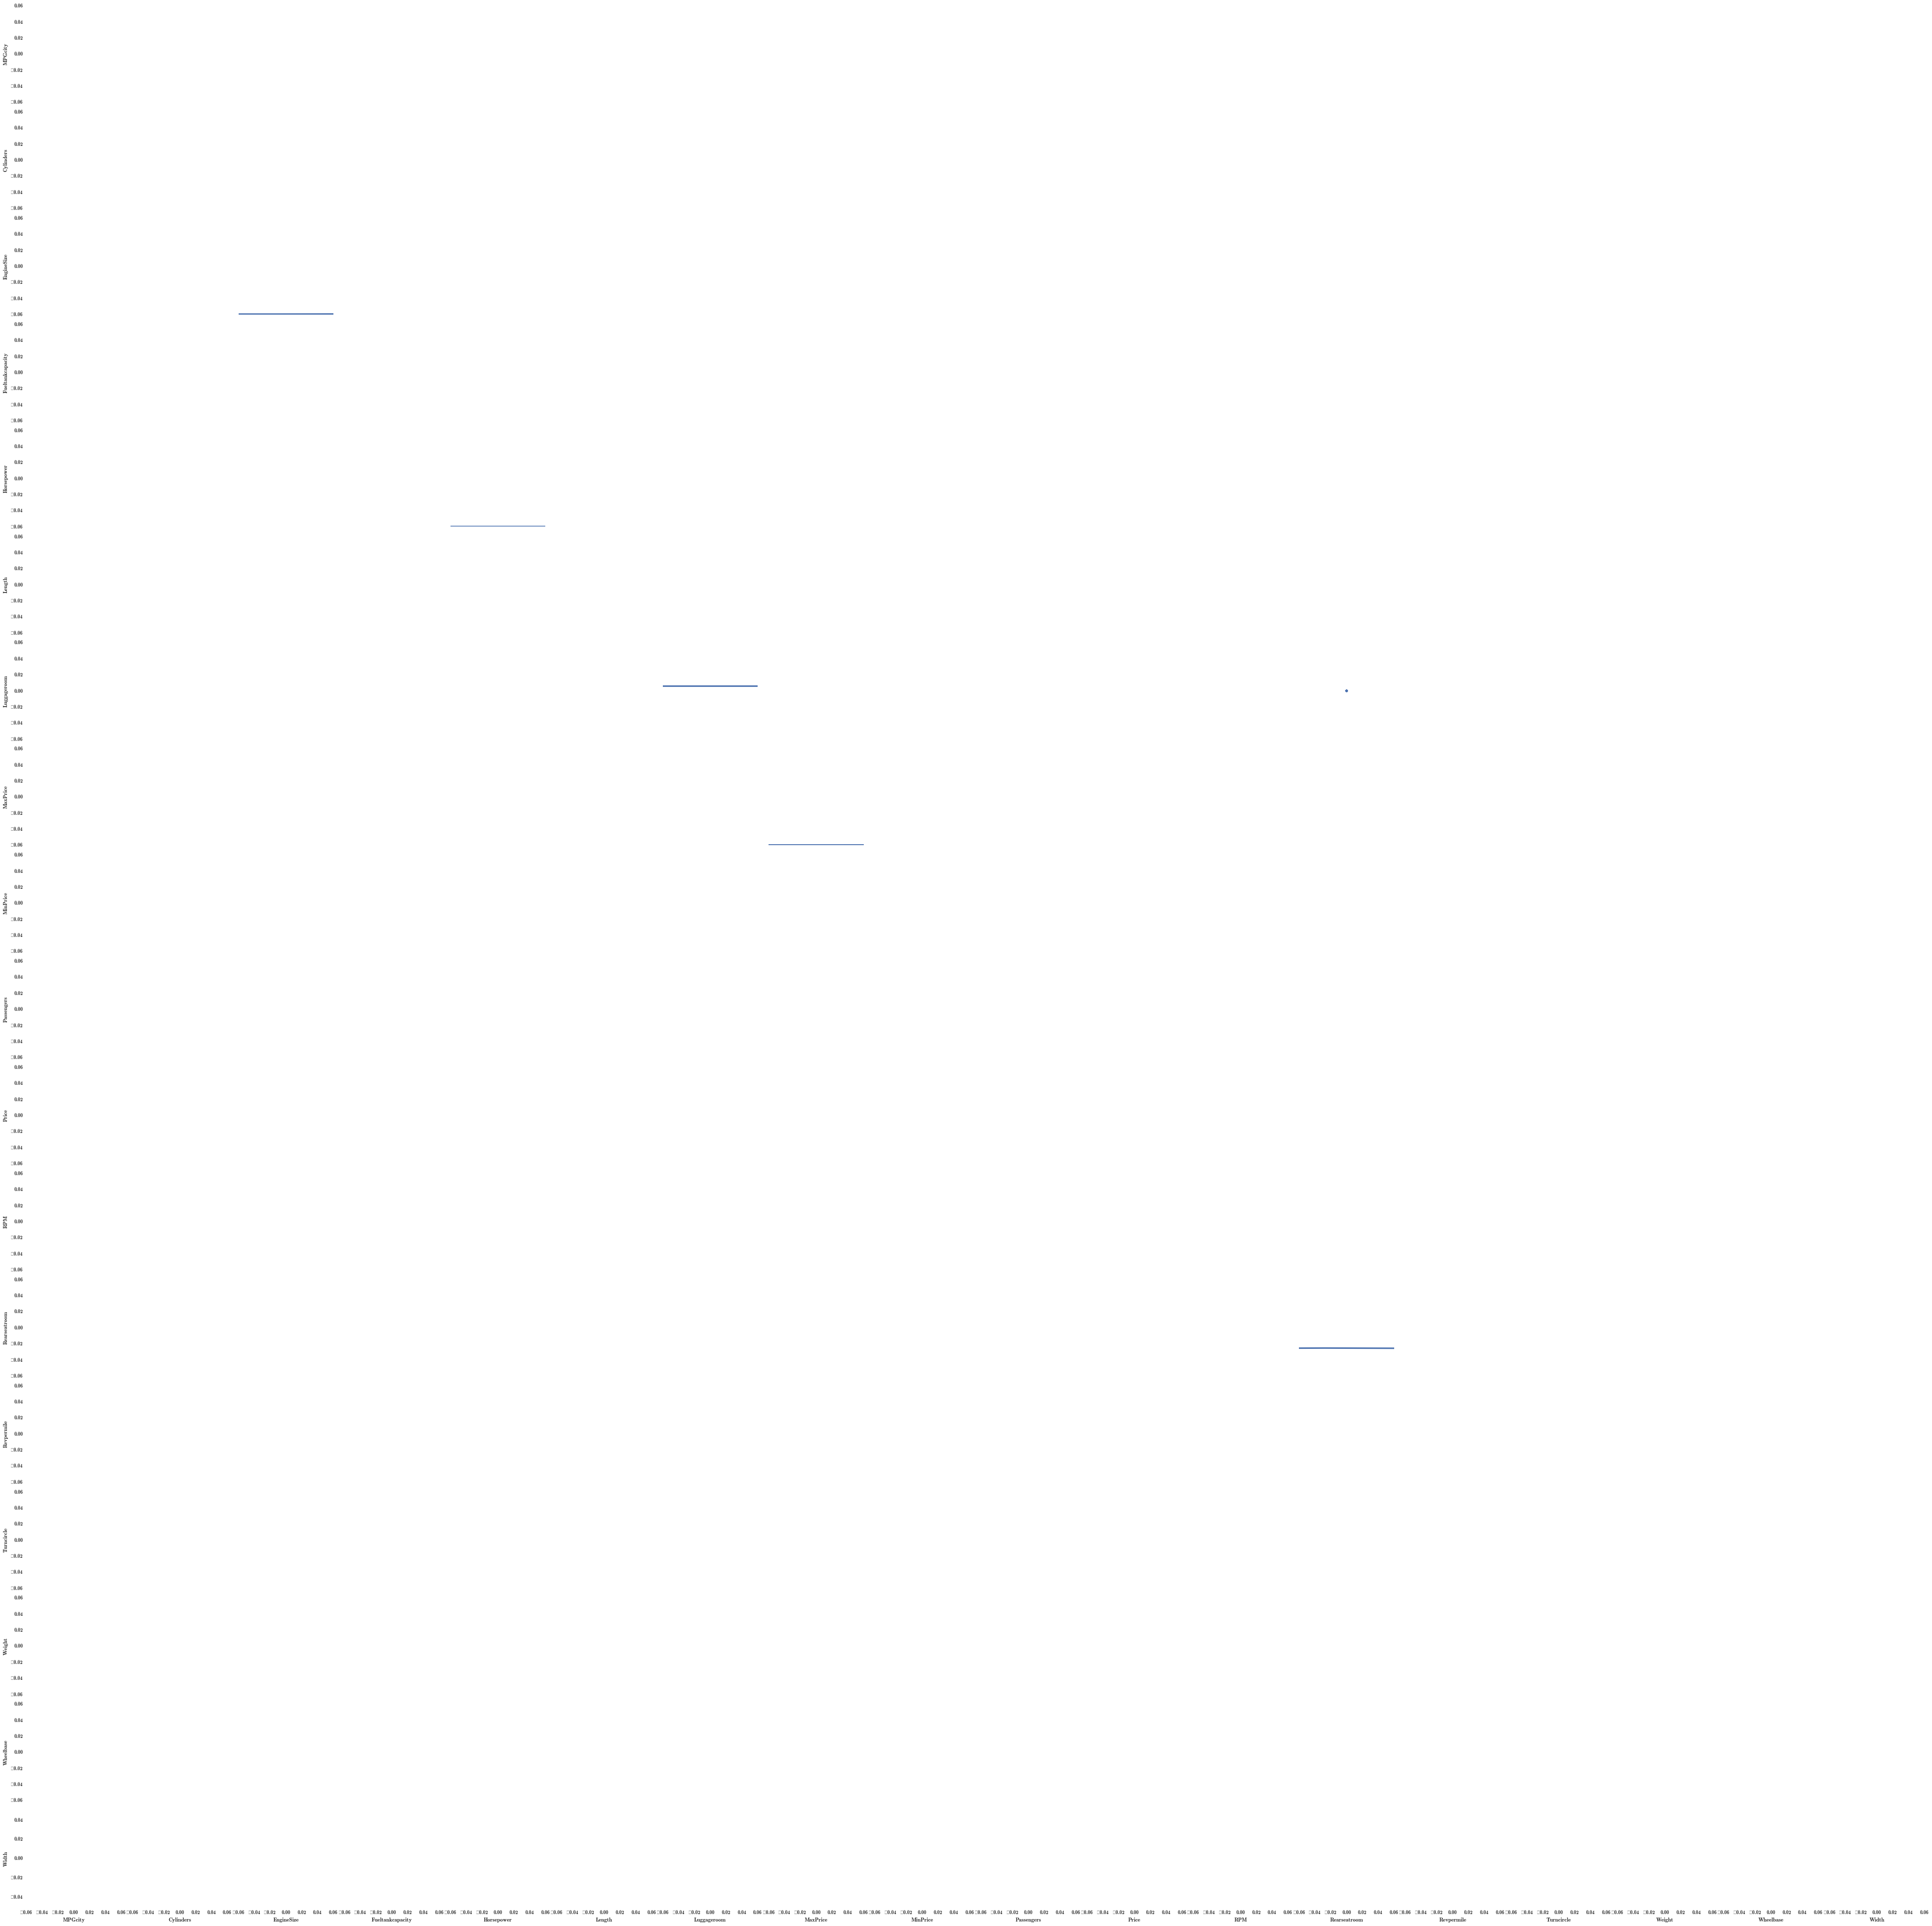

In [185]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

That gives us something to work with, but there's no clear slam dunk. also, various features appear to have a curvilinear relation with MPG.

### F Values

The "F value'' statistics tests the overall significance of the regression model.  Specifically, it tests the null hypothesis that all of the regression coefficients are equal to zero.  This tests the full model against a model with no variables and with the estimate of the dependent variable being the mean of the values of the dependent variable.  The F value is the ratio of the mean regression sum of squares divided by the mean error sum of squares.  Its value will range from zero to an arbitrarily large number.

The null hypothesis is rejected if the F ratio is large. Some analysts recommend ignoring the P values for the individual regression coefficients if the overall F ratio is not statistically significant, because of the problems caused by multiple testing. Here we'll reject the features if they are smaller than 10.



In [186]:
# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(X,y)[0] < 10)

2

In [187]:
# Which column are we talking about?
select = f_regression_feature_selection(X,y)[0] < 10
X.columns[select]

Index([u'Luggageroom', u'Rearseatroom'], dtype='object')

The two columns we replaced the missing values! At this point I'm more than happy to drop them.

In [188]:
# difference between the ones available and the ones we wish to drop
select = pd.Index(X.columns).difference(pd.Index(X.columns[select]))

Xs = X[select]

In [189]:
Xs.head()

,Cylinders,EngineSize,Fueltankcapacity,Horsepower,Length,MaxPrice,MinPrice,Passengers,Price,RPM,Revpermile,Turncircle,Weight,Wheelbase,Width
0,4,1.8,13.2,140,177,18.8,12.9,5,15.9,6300,2890,37,2705,102,68
1,6,3.2,18.0,200,195,38.7,29.2,5,33.9,5500,2335,38,3560,115,71
2,6,2.8,16.9,172,180,32.3,25.9,5,29.1,5500,2280,37,3375,102,67
3,6,2.8,21.1,172,193,44.6,30.8,6,37.7,5500,2535,37,3405,106,70
4,4,3.5,21.1,208,186,36.2,23.7,4,30.0,5700,2545,39,3640,109,69


### P values

In [190]:
# How many features don't meet the F test threshold?
sum(f_regression_feature_selection(Xs,y)[1] > 0.05)

0

Great! All of our predictors are significant ( p < 0.05 ) in a univariate regression.

The homework asked to select featured based on their P value.

In [ ]:
# Sort the features based on their statistical significance 
ps = f_regression_feature_selection(Xs,y)[1]

p_score = zip(Xs.columns, ps)
ranked_p = sorted(p_score, key=lambda x:x[1])
ranked_p

Now, we don't have the full toolkit yet to guard against overfitting - we'll introduce this after the break - but this is how you would loop through the various features and see the scores.

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
# Let's first build univariate models to see how well each individual features performs
scores = []
for feat, score in ranked_p:
    est = Ridge()
    X = [[x] for x in Xs[feat]]
    est.fit(X,y)
    scores.append(est.score(X,y))

In [ ]:
# Drop of R^2 with strong to weakest features
plt.plot(range(len(scores)), scores)

The first 3 features seem to be reasonably powerful, after which the next 6 features are mediocre, and the remaining features aren't useful by themselves and will likely be dropped. 

In [ ]:
# Now let's build models which cummatively look well combinations of features performs
scores = []
feats = []
for feat, score in ranked_p:
    est = Ridge()
    feats.append(feat)
    if len(feats) == 1:
        X = [[x] for x in Xs[feat]]
    else:
        X = Xs[feats]
    est.fit(X, y)
    scores.append(est.score(X,y))

In [ ]:
# Drop of R^2 with strong to weakest features
plt.plot(range(len(scores)), scores)

The first feature `Weight` is of course the most important, but the second and third features don't give us as much lift as we might have hoped for. This might have been due to the first three values being highly multicollinear. Let's inspect.

In [ ]:
correlation = Xs[[x[0] for x in ranked_p][:3]]

In [ ]:
sns.corrplot(correlation)

Compare this with the correlation plot of the whole dataset, and indeed! Apart from price correlating with min- and max-price, these are some of the most highly correlated features.

In [ ]:
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.corrplot(Xs, annot=False, sig_stars=False,
             diag_names=False, cmap=cmap, ax=ax)
f.tight_layout()

So, based on the P values, the most important features are

In [ ]:
p_features = [x[0] for x in ranked_p][:5]
p_features

Based on the the following plot, the feature which provide the largest improvement in R^2 are features [0,3,5], just out of interest, let's also build and score a model with only those features. 

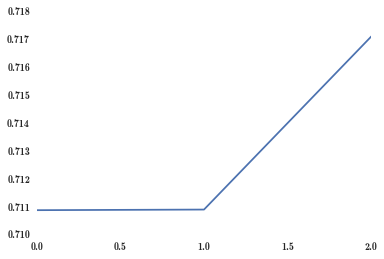

In [136]:
# Drop of R^2 with strong to weakest features
plt.plot(range(len(scores)), scores)

In [144]:
handpicked_features = [ranked_p[x][0] for x in [0,3,5]]
print handpicked_features

IndexError: list index out of range

In [140]:
est = Ridge()
X = Xs[handpicked_features]
est.fit(X, y).score(X,y)

0.71711325068131448

Even though the addition of these features was pivotal for the previous cummalative model, when just taken alone 

### Recursive feature elimination

We could have also decided to use [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and weights are assigned to each one of them. Then, features whose absolute weights are the smallest are pruned from the current set features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Since the RFE used our _coefficient size_ as a determinant of importance, we need to make sure we **standardise the data first**! This way the mean is always close to zero, and the standard deviation is one. 

In [141]:
stand_Xs = (Xs - Xs.mean()) / Xs.std()

In [142]:
from sklearn.feature_selection import RFE

# Create the RFE object and rank each features
est = Ridge()
rfe = RFE(estimator=est, n_features_to_select=1, step=1)

rfe.fit(stand_Xs, y)
ranking = rfe.ranking_

scores = zip(Xs.columns,ranking)
scores = sorted(scores, key=lambda x:x[1])

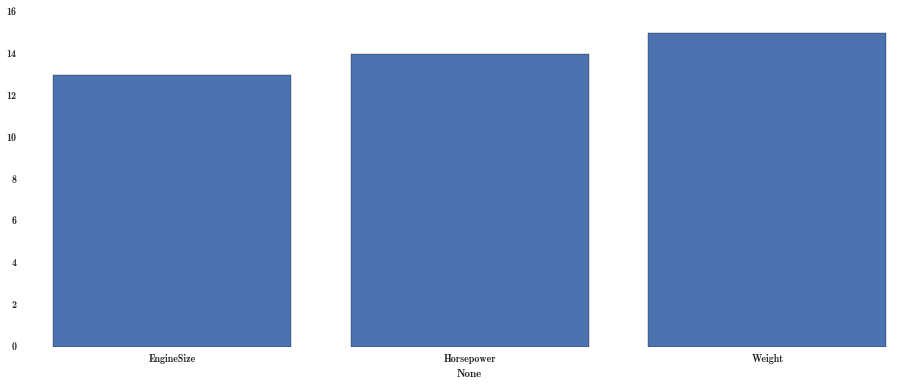

In [143]:
# Feature Importance 
plt.figure(figsize=(16, 6))
sns.barplot(Xs.columns, 16 - ranking);

So, how did the automatic RFE do compared to our own more manual feature selection?

In [ ]:
rfe_features = [x[0] for x in scores][:5]
print 'P Value:', p_features
print 'RFE Value:', rfe_features
print 'Handpicked Values:', handpicked_features

In [ ]:
for feats in [handpicked_features, p_features, rfe_features]:
    est = Ridge()
    X = Xs[feats]
    print est.fit(X, y).score(X,y)

The RFE feature selection delivered the strongest model.

### Polynominal Features

In [138]:
from patsy import dmatrix

We will expand on polynominal feature selection once we introduce cross-validation, but for now let's use Ridge Regression to prevent against overfitting. Let's continue with the features found by the RFE.

In [139]:
rfe_features

NameError: name 'rfe_features' is not defined

In [ ]:
poly_features = []

In [ ]:
[poly_features.append(dmatrix('C('+ str(feat) +', Poly)', Xs)) for feat in rfe_features];

In [ ]:
poly_features

Let's build a new dataframe which has all the polynomial columns

In [ ]:
poly_featurs_123 = [poly[:, 1:4] for poly in poly_features]

In [ ]:
p = poly_featurs_123

dfs = [pd.DataFrame(p[x]) for x in range(5)]
dfs = pd.concat(dfs, axis=1)

We need to rewrite the columns names since they got lost in the transformation

In [ ]:
column_names = [name + '^' + str(e) for name in rfe_features for e in range(1,4)]
column_names

In [ ]:
dfs.columns = column_names

In [ ]:
dfs

Now, finally, let's build a model with our 5 features all with 3rd order polynomimials.

In [ ]:
est = Ridge()
print "R^2 of %.02f based on %s features" % (est.fit(dfs, y).score(dfs,y), len(dfs.columns))

The model didn't improve spectacularly, so until we are better equiped to evaluated our models, we ought to stick with the linear model.

#### PolynomialFeatures

Alternatively, you can use the `PolynomialFeatures` function from Scikit-Learn.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(3)
poly_Xs = poly.fit_transform(Xs)

How many features did we create?

In [ ]:
len(poly_Xs) - len(Xs.columns)

Yep - close to 100 features. Just for kicks, how close to 1 could we push our R^2?

In [ ]:
est = Ridge()
print "R^2 of %.02f based on %s features" % (est.fit(poly_Xs, y).score(poly_Xs,y), len(poly_Xs))

Yep - perfect model - perfectly overfit that is! We'll see soon how to deal with this.